---

## **OPTIMIZACIÓN DEL CONSUMO ENERGÉTICO:**
## **IDENTIFICACIÓN DE PATRONES DE CALENTAMIENTO QUE REDUZCAN EL CONSUMO ENERGÉTICO (FAMILIA DE RESULFURADOS)**

---

**Autor:** Sergio Bolívar Gómez

**Fecha de creación:** 25 de mayo de 2023.

**Última modificación:** 7 de julio de 2023.


## **OBJETIVO**

El objetivo de este notebook es aplicar RL para identificar patrones de calentamiento de las palanquillas que reduzcan el consumo de energía del horno con respecto a los tratamientos aplicados por GSW en la actualidad. Para ello, se aplicará la política de toma de decisiones aprendida en el notebook `training-deep-q-learning.ipynb` (los pesos del agente o deep Q-network están en `/code/4-energy-optimization/models_avg_pattern/deep-q-network-trained-best-performance.h5`) tomando como estado inicial el patrón de calentamiento utilizado actualmente por GSW para cada palanquilla. En otras palabras, se tomará el patrón de calentamiento de cada palanquilla, y se irán tomando acciones siguiendo un criterio epsilon-greedy que da más peso a la explotación de la DQN que a la exploración (aleatoriedad). La acción seleccionada por la DQN en cada step es aquella que maximiza el Q-value (el fundamento del deep Q-learning).

In [108]:
case_study_billet = "6211358"

## **IMPORTACIÓN DE LIBRERÍAS**

Importamos algunas de las librerías que vamos a utilizar en este notebook:


In [109]:
import os # para interacturar con el sistema
import pandas as pd # para manejar DataFrames
import numpy as np # para manejar arrays y hacer operaciones sobre ellos
import matplotlib.pyplot as plt # para hacer gráficas
import seaborn as sns # para hacer gráficas más avanzadas
import math # para hacer algunas operaciones
import glob # para aglutinar archivos
import copy # para hacer copias de objetos de Python
import pickle # para guardar diccionario de Python en ficheros
import random # para hacer elecciones aleatorias y establecer semillas
import time # para llevar un registro del tiempo de ejecución

from scipy.interpolate import interp1d # para remuestrear señal
from datetime import datetime # para formatear fechas
from tqdm import tqdm # para hacer bucles más elegantes y ver su progreso
from collections import deque

In [110]:
# Para usar la fuente de LaTex en los plots
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']

## **IMPORTACIÓN Y PREPROCESADO DE LOS DATOS**

En primer lugar, construimos una lista que contiene los identificadores de las palanquillas simuladas.


In [111]:
output_files_path = "/home/bolivars/Escritorio/data/preprocessed/files-to-ml/outputs" # CHANGEME: esto es un path a una carpeta con los inputs/outputs de las palanquillas simuladas

simul_billets = [] # esta lista contendrá los identificadores de las palanquillas que se han simulado

for filename in os.listdir(output_files_path): # recorremos los archivos del path anterior
    if filename.startswith("resultados_caso_estudio_palanquilla_") and filename.endswith(".csv"):
        number = filename.split("_")[-1].split(".")[0] # extraemos el identificador de la palanquilla
        simul_billets.append(number) # añadimos el identificador de la palanquilla a la lista

simul_billets.sort() # ordenamos la lista

In [112]:
print(f"NÚMERO DE PALANQUILLAS SIMULADAS: {len(simul_billets)}")

NÚMERO DE PALANQUILLAS SIMULADAS: 217


En segundo lugar, creamos un diccionario con información sobre las palanquillas simuladas (longitud, diámetro, hilo, material, calidad/familia...).

In [113]:
info_palanquillas_db = {} # este diccionario contendrá la información relativa a las palanquillas; siendo sus keys los IDs correspondientes

long_path = "/home/bolivars/Escritorio/data/raw/additional-info"  # CHANGEME: path que lleva a la información de las palanquillas

file_pattern = os.path.join(long_path, "long_*.csv") # patrón útil para localizar los ficheros con información sobre las palanquillas
long_files = glob.glob(file_pattern) # lista con todos los ficheros proporcionados por GSW

data_to_store = ["long_punta", "long_cola", "diametro", "hilo", "material", "calidad"] # variables que representan la información que queremos almacenar

for long_data_file in long_files: # recorremos los ficheros proporcionados por GSW

    original_data = pd.read_csv(long_data_file, sep = ',', decimal = ".", # leemos los datos originales desde el CSV
                                usecols=lambda col: col != "Unnamed: 0") # eliminamos la variable unnamed (basura)
    
    data_grouped_by_bulto = original_data.groupby('bulto') # agrupamos los datos según el bulto (identificador de la palanquilla)

    for name, group in data_grouped_by_bulto:

        palanquilla_info = {k: pd.DataFrame(group)[k].values[0] for k in data_to_store} # diccionario que contendrá la información especificada en la lista 'info_to_store'  

        info_palanquillas_db[name] = palanquilla_info # la key es el bulto de la palanquilla (identificador); el value el diccionario con toda la información

Finalmente, creamos un diccionario que contiene toda la información relativa a la simulaciones (inputs, outputs, información sobre las palanquillas simuladas...).

In [114]:
billets_db = {} # creamos un diccionario que contenga toda la información relativa a las simulaciones (inputs/outputs ANSYS + ML)

for billet in simul_billets:

    input_path = f"/home/bolivars/Escritorio/data/preprocessed/files-to-ml/inputs/caso_estudio_palanquilla_{billet}.csv" # CHANGEME: path a los inputs
    output_path = f"/home/bolivars/Escritorio/data/preprocessed/files-to-ml/outputs/resultados_caso_estudio_palanquilla_{billet}.csv" # CHANGEME: path a los outputs

    info_to_store = ["inputs_ansys", "inputs_ML", "outputs_ansys", "outputs_ML"] # información que queremos almacenar

    billet_temp = {k: None for k in info_to_store} # diccionario que contendrá la información especificada en la lista 'info_to_store'

    ## LECTURA DE INPUTS ##
    billet_temp["inputs_ansys"] = pd.read_csv(input_path, sep = ',', decimal = ".") # leemos los inputs de ANSYS desde el CSV    
    billet_temp["inputs_ML"] = pd.read_csv(input_path, sep = ',', decimal = ".").drop_duplicates(subset=['posicion'], keep='first') # eliminamos los datos artificiales añadidos hasta llegar a tamaño 200 (fijado para la simulación)
    
    ## LECTURA DE OUTPUTS ##
    billet_temp["outputs_ansys"] = pd.read_csv(output_path, sep = ',', decimal = ".")

    # INTERPOLO LOS OUTPUTS DE ANSYS AL TAMAÑO DEL INPUT (SIN AÑADIR LOS CEROS)
    new_size = billet_temp["inputs_ML"].shape[0] # tamaño original del input (sin los 0s añadidos de manera artificial)
    pos_temp = billet_temp["outputs_ansys"][["posicion", "temperatura"]].values # valores de posición y temperatura
    new_indices = np.linspace(0, len(pos_temp)-1, new_size) # nuevos índices
    resampled_pos_temp = np.zeros((new_size, 2))

    resampled_pos_temp[:, 0] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 0]) # interpolamos posición
    resampled_pos_temp[:, 1] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 1]) # interpolamos temperatura

    billet_temp["outputs_ML"] = pd.DataFrame({'posicion': resampled_pos_temp[:,0], 'temperatura': resampled_pos_temp[:,1]}) # guardamos los outputs interpolados

    # REDUZCO LA DIMENSIÓN DE LOS OUTPUTS DE ANSYS
    new_size = 50 # tamaño del vector reducido de outputs
    pos_temp = billet_temp["outputs_ansys"][["posicion", "temperatura"]].values # valores de posición y temperatura
    new_indices = np.linspace(0, len(pos_temp)-1, new_size) # nuevos índices en el sistema reducido
    resampled_pos_temp = np.zeros((new_size, 2))

    resampled_pos_temp[:, 0] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 0]) # interpolamos posición
    resampled_pos_temp[:, 1] = np.interp(new_indices, np.arange(len(pos_temp)), pos_temp[:, 1]) # interpolamos temperatura

    billet_temp["outputs_ML_reduced"] = pd.DataFrame({'posicion': resampled_pos_temp[:,0], 'temperatura': resampled_pos_temp[:,1]}) # guardamos los outputs reducidos

    for item in data_to_store: # añado al diccionario global la información adicional sobre la palanquilla (longitud, material, hilo...)
        billet_temp[item] = info_palanquillas_db[int(billet)][item]
        
    # GUARDADO DE DATOS
    billets_db[billet] = billet_temp # asociamos cada palanquilla con sus datos correspondientes
    
else:
    position_index = billets_db[billet]["outputs_ML_reduced"]["posicion"].copy() # nuevo vector de posición interpolado al tamaño de 'new_size' (para hacer gráficas)

## **PREPARATIVOS PARA LA NORMALIZACIÓN**

Hay que tener en cuenta que los modelos de ML han sido entrados para datos normalizados, por lo que hay que recuperar los valores máximos y mínimos de cada variable en el conjunto de entrenamiento para poder normalizar los patrones de calentamiento utilizando el criterio min-max.

In [115]:
random.seed(2023) # reproducibilidad
billets_test = random.sample(simul_billets, 17) # escogemos 17 palanquillas aleatoriamente para construir conjunto de test
billets_train = set(simul_billets) - set(billets_test) # el resto forma el conjunto de entrenamiento

In [116]:
advance = [] # lista que contendrá todos los valores del avance
power_inductor_g1 = [] # lista que contendrá todos los valores de la potencia del primer grupo de inductores
power_inductor_g2 = [] # lista que contendrá todos los valores de la potencia del segundo grupo de inductores
power_inductor_g3 = [] # lista que contendrá todos los valores de la potencia del tercer grupo de inductores
power_inductor_g4 = [] # lista que contendrá todos los valores de la potencia del cuarto grupo de inductores

for billet in billets_train:

    input_data = billets_db[billet]["inputs_ansys"].copy()
    input_data = input_data.drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1) 

    advance.extend(list(input_data["avance"].values))
    power_inductor_g1.extend(list(input_data["IND_1"].values))
    power_inductor_g2.extend(list(input_data["IND_2"].values))
    power_inductor_g3.extend(list(input_data["IND_3"].values))
    power_inductor_g4.extend(list(input_data["IND_4"].values))

else:

    min_advance = min(advance) # valor mínimo del avance
    max_advance = max(advance) # valor máximo del avance

    min_power_inductor_g1 = min(power_inductor_g1) # valor mínimo de la potencia del primer grupo de inductores
    max_power_inductor_g1 = max(power_inductor_g1) # valor máximo de la potencia del primer grupo de inductores

    min_power_inductor_g2 = min(power_inductor_g2) # valor mínimo de la potencia del segundo grupo de inductores
    max_power_inductor_g2 = max(power_inductor_g2) # valor máximo de la potencia del segundo grupo de inductores

    min_power_inductor_g3 = min(power_inductor_g3) # valor mínimo de la potencia del tercer grupo de inductores
    max_power_inductor_g3 = max(power_inductor_g3) # valor máximo de la potencia del tercer grupo de inductores

    min_power_inductor_g4 = min(power_inductor_g4) # valor mínimo de la potencia del cuarto grupo de inductores
    max_power_inductor_g4 = max(power_inductor_g4) # valor máximo de la potencia del cuarto grupo de inductores

## **RL PARA IDENTIFICAR PATRONES QUE REDUZCAN EL CONSUMO ENERGÉTICO**

Conectamos la GPU para agilizar el proceso de entrenamiento de las redes neuronales...

In [117]:
import tensorflow as tf
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if len(tf.config.list_physical_devices('GPU')):
    print(f"LA GPU SE HA CONECTADO CORRECTAMENTE. HAY {len(tf.config.list_physical_devices('GPU'))} DISPONIBLE :)")

Importamos algunas librerías útiles para el entrenamiento...

In [118]:
from tensorflow import keras # importamos Keras
from tensorflow.keras.models import Sequential # importamos el modelo secuencial (otra opción sería usar uno funcional)
from tensorflow.keras.layers import * # importamos todas las capas de Keras
from tensorflow.keras.losses import MeanSquaredError # importamos algunas funciones de pérdida
from tensorflow.keras.optimizers import Adam, RMSprop # importamos algunos optimizadores
from tensorflow.keras.metrics import RootMeanSquaredError # importamos algunas métricas
from tensorflow.keras import regularizers # importamos regularizadores para evitar overfitting
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # importamos los callbacks para el modelo
from tensorflow.keras import initializers

#### **ESTADO INICIAL**

In [119]:
##################
# ESTADO INICIAL #
##################

# En este caso, no queremos entrenar la DQN, sino explotarla. Por ello, el estado inicial ahora es el patrón de calentamiento empleado por GSW.
# El objetivo es ir modificando este patrón mediante la selección de acciones motivadas por el agente/DQN, de manera que lleguemos a patrones de calentamiento
# cuyo perfil de temperatura asociado sea similar al perfil objetivo, a la vez que se reduce el consumo de energía.

INITIAL_STATE = billets_db[case_study_billet]["inputs_ansys"].copy().drop(["tiempo", "velocidad", "inlet_temp", "outlet_temp", "posicion"], axis=1).to_numpy().ravel()

INITIAL_STATE_BACKUP = INITIAL_STATE.copy()

STATES_SIZE = INITIAL_STATE.shape # tamaño de los estados

#### **PERFIL OBJETIVO**

In [120]:
###################
# PERFIL OBJETIVO #
###################

# En esta primera aproximación, el perfil de temperaturas objetivo se corresponde con el perfil de temperaturas medio asociado a la
# familia de resulfurados. En otras palabras, el perfil de temperaturas deseado lo obtenemos haciendo la media de los perfiles de
# temperatura simulados para las 18 palanquillas de la familia de resulfurados.


DESIRED_TEMPERATURE_PROFILE = np.array(billets_db["6211341"]["outputs_ML_reduced"]["temperatura"].copy()) # perfil arbitrario para mantener formato

DESIRED_TEMPERATURE_PROFILE = 0*DESIRED_TEMPERATURE_PROFILE # multiplico por cero para mantener formato

for billet in list(billets_db.keys())[11:29]:
    DESIRED_TEMPERATURE_PROFILE += np.array(billets_db[billet]["outputs_ML_reduced"]["temperatura"].copy())

DESIRED_TEMPERATURE_PROFILE = DESIRED_TEMPERATURE_PROFILE/len(list(billets_db.keys())[11:29])

DESIRED_TEMPERATURE_PROFILE_BACKUP = DESIRED_TEMPERATURE_PROFILE.copy()

Representamos el perfil de temperaturas objetivo...

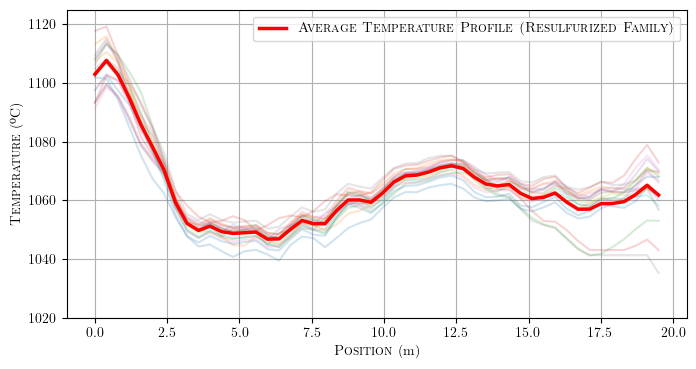

In [121]:
fig, ax = plt.subplots(figsize=(8, 4))

# RECORREMOS TODAS LAS PALANQUILLAS DE RESULFURADO
for billet in list(billets_db.keys())[11:29]:
    ax.plot(billets_db[billet]["outputs_ML_reduced"]["posicion"], billets_db[billet]["outputs_ML_reduced"]["temperatura"], alpha = 0.2)
    ax.set_xlabel(r"\textsc{Position} (m)")
    ax.set_ylabel(r"\textsc{Temperature} (ºC)")
    ax.set_ylim(1020, 1125)

example_billet = "6211341"
ax.plot(billets_db[example_billet]["outputs_ML_reduced"]["posicion"], DESIRED_TEMPERATURE_PROFILE, linewidth=2.5, color="red", label=r"\textsc{Average Temperature Profile (Resulfurized Family)}")

ax.legend()
ax.grid()
plt.show()

#### **IMPORTACIÓN DEL MODELO DE ML**

In [122]:
#############
# MODELO ML #
#############

MODEL_ML_FURNACE = keras.models.load_model("/home/bolivars/Escritorio/code/3-machine-learning-models/convolutional-recurrent-model/convolutional-recurrent-model-best-performance.h5")

#### **ESPACIO DE ACCIONES**

In [123]:
#######################
# ESPACIO DE ACCIONES #
#######################

ACTION_SPACE = [] # conjunto de las posibles acciones (es preciso discretizar este espacio)

num_rows = 20 # número de steps que se modifican en cada acción
stride = 5 # salto de un instante a otro de la serie temporal multivariante (hay que saltar 5 variables)
action_window = num_rows * stride # número de elementos total que es necesario saltar

oper_quantity = [(0, [0.85, 0.9, 0.01, 1.1, 1.15])]
# oper_quantity = [(0, [0.8, 0.85, 0.9, 1.1, 1.15, 1.2]), (-1, [10, 100]), (1, [10, 100])]

for i in range(0, INITIAL_STATE.shape[0], action_window):
    for k in range(1,5):
        for operation, quantities in oper_quantity:
            for quantity in quantities:
                action = (i+k, i+action_window, stride, operation, quantity) # action = (start, stop, step, operation, quantity)
                ACTION_SPACE.append(action) 

ACTION_SPACE_SIZE = len(ACTION_SPACE)

print(f"EL NÚMERO DE ACCIONES CONSIDERADAS SON {ACTION_SPACE_SIZE}.")

EL NÚMERO DE ACCIONES CONSIDERADAS SON 200.


#### **ENTORNO VIRTUAL: SIMULADOR DEL HORNO - MODELO DE ML**

In [124]:
###########
# ENTORNO #
###########

class FurnaceEnvironment:

    # CONSTRUCTOR
    def __init__(self, initial_state, desired_pattern, action_space, model_ml_furnace):
        self.initial_state = initial_state.copy() # estado incial
        self.desired_pattern = desired_pattern.copy() # patrón de temperatura deseado/objetivo
        self.action_space = action_space.copy()
        self.model_ml_furnace = model_ml_furnace
    
    # RESETEAR AL ESTADO INCIAL
    def reset(self):
        self.state = self.initial_state.copy() # el estado tras hacer reset es el estado inicial
        self.episode_step = 0 # tras hacer un reset, el contador de pasos relativo al episodio se pone a cero
        return self.state
    
    # APLICA LA ACCIÓN, RETORNANDO EL NUEVO ESTADO, LA RECOMPENSA Y UN INDICADOR QUE INDICA SI SE ALCANZA EL OBJETIVO
    def step(self, action):

        # INICIALIZACIÓN/ACTUALIZACIÓN DE PARÁMETROS
        self.episode_step += 1 # cada vez que se aplique una acción, aumentamos el contador de los steps del episodio
        done = False # indica si se ha llegado al objetivo

        # ACTUALIZACIÓN DEL ESTADO:
        start, end, step, operation, quantity = self.action_space[action] # selección de la acción     
        positions = np.arange(start, end, step) # posiciones del estado que se van a modificar

        next_state = self.state

        if operation==0:
            next_state[positions] *= quantity
            next_state[positions] = np.minimum(next_state[positions], 1000) # impongo un tope superior de 1000 kW de potencia
        elif operation==1:
            next_state[positions] += quantity
            next_state[positions] = np.minimum(next_state[positions], 1000) # impongo un tope superior de 1000 kW de potencia
        elif operation==-1:
            next_state[positions] -= quantity
            next_state[positions] = np.maximum(next_state[positions], 0) # si obtengo una potencia negativa, la hago cero

        self.state = next_state

        # PREDICCIÓN DEL PERFIL DE TEMPERATURAS ASOCIADO AL NUEVO ESTADO UTILIZANDO EL MODELO DE ML:
        data = np.array(next_state).reshape(200,5).copy()

        # ESTIMAMOS EL CONSUMO ENERGÉTICO DEL NUEVO ESTADO (kWh) [antes de normalizar!]:
        energy_consumption = 1/3600*np.sum(data[:, 1:5]) # se asume que cada potencia se aplica durante un segundo (realmente el time step es un poco mayor, muy poco, pero es una estimación)

        # NORMALIZACIÓN (el modelo de ML trabaja con estados normalizados! Usamos los valores min/max del conjunto de entrenamiento del modelo de ML)
        data[:,0] = (data[:,0]-min_advance)/(max_advance-min_advance)
        data[:,1] = (data[:,1]-min_power_inductor_g1)/(max_power_inductor_g1 - min_power_inductor_g1)
        data[:,2] = (data[:,2]-min_power_inductor_g2)/(max_power_inductor_g2 - min_power_inductor_g2)
        data[:,3] = (data[:,3]-min_power_inductor_g3)/(max_power_inductor_g3 - min_power_inductor_g3)
        data[:,4] = (data[:,4]-min_power_inductor_g4)/(max_power_inductor_g4 - min_power_inductor_g4)

        input_data = np.transpose(data)
        input_data = input_data.reshape((-1, 5, 200), order='C')
        predicted_temp_profile = self.model_ml_furnace.predict(input_data, verbose=0)
        
        # CALCULAMOS LA RECOMPENSA:        
        RMSE = np.sqrt(np.mean((predicted_temp_profile - DESIRED_TEMPERATURE_PROFILE)**2)) # RMSE entre perfiles de temperatura

        CORR = np.corrcoef(DESIRED_TEMPERATURE_PROFILE, predicted_temp_profile)[0,1] # correlación entre perfiles de temperatura

        if RMSE >= 25:
            reward = -1_000_000 - RMSE
        elif 10 <= RMSE and RMSE < 25:
            reward = -10_000 - RMSE
        elif 7 <= RMSE and RMSE < 10:
            reward = -1_000 - RMSE
        elif 5 <= RMSE and RMSE < 7:
            reward = -100 - RMSE
        else:
            reward = (100 - energy_consumption)*CORR

        # CRITERIO DE PARADA: la recompensa es positiva (RMSE<5) y el consumo energético es menor de 10 (inferior al mínimo registrado entre las palanquillas de resulfurado)
        if (reward > 0 and energy_consumption < 10) or self.episode_step >= 50:
            done = True
            
        return self.state, reward, done, energy_consumption, RMSE

In [125]:
#########################
# AGENTE/DEEP Q-NETWORK #
#########################

class DeepQNetwork:

    # CONSTRUCTOR
    def __init__(self, replay_memory_size, min_replay_memory_size, minibatch_size, update_target_every, discount, action_space):

        # INICIALIZAR ALGUNAS VARIABLES
        self.replay_memory_size = replay_memory_size
        self.min_replay_memory_size = min_replay_memory_size
        self.minibatch_size = minibatch_size
        self.update_target_every = update_target_every
        self.discount = discount
        self.action_space = action_space
        
        self.target_update_counter = 0
        self.replay_memory = deque(maxlen=self.replay_memory_size)

        # MODELO PRINCIPAL
        self.model = self.create_model()

        # MODELO OBJETIVO
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())    

    # CONSTRUCTOR DE LA Q-NETWORK
    def create_model(self):

        model = Sequential()
        model.add(keras.layers.Dense(1024, input_shape = STATES_SIZE, activation="relu"))
        model.add(keras.layers.Dense(1024, activation="relu", kernel_initializer=initializers.HeNormal()))
        model.add(keras.layers.Dense(512, activation="relu", kernel_initializer=initializers.HeNormal()))
        model.add(keras.layers.Dense(256, activation="relu", kernel_initializer=initializers.HeNormal()))
        model.add(keras.layers.Dense(len(self.action_space), activation="linear"))
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), metrics=['mse'])
        
        return model
    
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    # ENTRENA EL MODELO PRINCIPAL EN CADA PASO DEL EPISODIO
    def train(self, terminal_state, step):

        # El entrenamiento empieza solo si se ha guardado un número mínimo de muestras
        if len(self.replay_memory) < self.min_replay_memory_size:
            return
        
        # Se obtiene un minibatch aleatorio del buffer
        minibatch = random.sample(self.replay_memory, self.minibatch_size)

        # Se obtienen los estados actuales para, a continuación, usar la NN para obtener los Q-values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states, verbose=0)

        # Se obtienen los estados futuros para, a continuación, usar la NN para obtener los Q-values
        # Si se utiliza el modelo objetivo, hay que consultarla; si no, hay que usar el modelo principal.
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states, verbose = 0)

        X = []
        y = []
        
        # Se enumeran los batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            
            # Si no es un estado terminal, obtener Q-value a partir de los estados futuros.
            # Si es terminal, el Q-value coincide con la recompensa (no hay estados futuros, max_future_q=0)
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + self.discount * max_future_q
            else:
                new_q = reward

            # Se actualizan los Q-values para el estado actual
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # Se añaden a los datos de entrenamiento
            X.append(current_state)
            y.append(current_qs)

        # Se entrena el modelo
        self.model.fit(np.array(X), np.array(y), batch_size=self.minibatch_size, verbose=0, shuffle=False)

        # Se actualiza el contador para el modelo objetivo en cada episodio
        if terminal_state:
            self.target_update_counter += 1

        # Se actualizan los pesos del modelo objetivo (con los del modelo principal) cuando el contador llega al límite establecido
        if self.target_update_counter > self.update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
        
    # Utiliza el modelo principal para hacer una predicción de los Q-values asociados al estado actual
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose = 0)[0]

#### **EJECUCIÓN DEL ALGORITMO DE RL**

In [126]:
############################
# INICIALIZAMOS EL ENTORNO #
############################

env = FurnaceEnvironment(INITIAL_STATE, DESIRED_TEMPERATURE_PROFILE, ACTION_SPACE, MODEL_ML_FURNACE)

In [127]:

###########################
# INICIALIZAMOS EL AGENTE #
###########################

REPLAY_MEMORY_SIZE = 10_000
MIN_REPLAY_MEMORY_SIZE = 64
MINIBATCH_SIZE = 64
UPDATE_TARGET_EVERY = 5
DISCOUNT = 0.7

agent = DeepQNetwork(REPLAY_MEMORY_SIZE, MIN_REPLAY_MEMORY_SIZE, MINIBATCH_SIZE, UPDATE_TARGET_EVERY, DISCOUNT, ACTION_SPACE)

In [128]:
# INICIALIZAMOS LOS PESOS DEL AGENTE

# Se inicializan los pesos del agente con los obtenidos en la fase de entrenamiento de la DQN (ahora no entrenamos! Solo usamos la política de toma de decisiones)

from tensorflow.keras.models import load_model

trained_model = load_model('/home/bolivars/Escritorio/code/4-energy-optimization/models_avg_pattern/deep-q-network-trained-best-performance.h5')
trained_weights = trained_model.get_weights()

agent.model.set_weights(trained_weights)
agent.target_model.set_weights(trained_weights)

In [129]:
# INICIALIZACIÓN DE ALGUNAS VARIABLES
EPISODES = 300

MAX_REWARD = -1_000_000_000

EPSILON = 0.2 # un epsilon muy pequeño significa que explotamos la política de toma de decisiones (nos fiamos de los Q-values predichos por DQN)

BEST_HEATING_PATTERN = []

In [130]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # suprimo warnings

In [131]:
# ITERAMOS SOBRE LOS EPISODIOS
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # RESET DEL EPISODIO
    current_state = env.reset() # reset del ESTADO
    actions_carried_out = [] # lista con las acciones llevadas a cabo   
    done = False # reset del indicador de FIN

    while not done:

        # MÉTODO ÉPSILON-GREEDY PARA ESCOGER UNA ACCIÓN
        if np.random.random() > EPSILON: # explotación
            # Se escoge la acción con mayor Q-value
            action = np.argmax(agent.get_qs(current_state))
        else: # exploración
            # Se escoge una acción de manera aleatoria
            action = np.random.randint(0, len(env.action_space))

        actions_carried_out.append(action)

        # NUEVO ESTADO BASADO EN LA ACCIÓN ESCOGIDA
        new_state, reward, done, energy_consumed, rmse = env.step(action)

        # Se guardan los estados solo cuando se supera la recompensa anterior
        if reward > MAX_REWARD:
            env.episode_step -= 100 # para que si va en la dirección correcta dentro de un episodio, no sea un problema el límite de steps
            BEST_STATE = new_state.copy()
            MAX_REWARD = reward
            BEST_HEATING_PATTERN.append((BEST_STATE, MAX_REWARD, actions_carried_out))
            print(f"PATRÓN ÓPTIMO ENCONTRADO (EPISODIO {episode}) => RECOMPENSA: {round(reward,2)} || CONSUMO ENERGÉTICO: {round(energy_consumed,2)} kWh || RMSE: {round(rmse,2)} ºC || Nº ACCIONES: {len(actions_carried_out)} || EPSILON: {round(EPSILON,3)}.")

        current_state = new_state

  0%|          | 0/300 [00:00<?, ?episodes/s]

PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 1) => RECOMPENSA: -106.92 || CONSUMO ENERGÉTICO: 8.52 kWh || RMSE: 6.92 ºC || Nº ACCIONES: 1 || EPSILON: 0.2.
PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 1) => RECOMPENSA: -106.44 || CONSUMO ENERGÉTICO: 8.64 kWh || RMSE: 6.44 ºC || Nº ACCIONES: 73 || EPSILON: 0.2.
PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 1) => RECOMPENSA: -106.42 || CONSUMO ENERGÉTICO: 8.52 kWh || RMSE: 6.42 ºC || Nº ACCIONES: 133 || EPSILON: 0.2.


  1%|          | 2/300 [00:26<56:17, 11.33s/episodes]  

PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 3) => RECOMPENSA: -105.05 || CONSUMO ENERGÉTICO: 10.91 kWh || RMSE: 5.05 ºC || Nº ACCIONES: 1 || EPSILON: 0.2.


  8%|7         | 23/300 [01:36<13:56,  3.02s/episodes]

PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 24) => RECOMPENSA: 86.97 || CONSUMO ENERGÉTICO: 11.22 kWh || RMSE: 4.86 ºC || Nº ACCIONES: 1 || EPSILON: 0.2.


 33%|###3      | 100/300 [05:42<10:21,  3.11s/episodes]

PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 101) => RECOMPENSA: 87.18 || CONSUMO ENERGÉTICO: 11.01 kWh || RMSE: 4.95 ºC || Nº ACCIONES: 1 || EPSILON: 0.2.


 99%|#########9| 298/300 [15:27<00:06,  3.05s/episodes]

PATRÓN ÓPTIMO ENCONTRADO (EPISODIO 299) => RECOMPENSA: 87.46 || CONSUMO ENERGÉTICO: 10.73 kWh || RMSE: 4.9 ºC || Nº ACCIONES: 22 || EPSILON: 0.2.


100%|##########| 300/300 [15:38<00:00,  3.13s/episodes]


In [132]:
BEST_HEATING_PATTERN = sorted(BEST_HEATING_PATTERN, key=lambda x: -x[1])

OPTIM_STATE = BEST_HEATING_PATTERN[0][0]

print(f"LA RECOMPENSA MÁS ALTA QUE SE HA OBTENIDO ES {round(BEST_HEATING_PATTERN[0][1],2)}.\n")

print(f"POLÍTICA DE ACCIONES A SEGUIR PARA LLEGAR AL ESTADO ÓPTIMO A PARTIR DEL ESTADO INCIAL [{len(BEST_HEATING_PATTERN[0][2])} accciones llevadas a cabo]:\n")
print(BEST_HEATING_PATTERN[0][2])

LA RECOMPENSA MÁS ALTA QUE SE HA OBTENIDO ES 87.46.

POLÍTICA DE ACCIONES A SEGUIR PARA LLEGAR AL ESTADO ÓPTIMO A PARTIR DEL ESTADO INCIAL [150 accciones llevadas a cabo]:

[39, 128, 128, 128, 128, 128, 91, 128, 128, 128, 128, 133, 128, 128, 110, 72, 128, 128, 128, 128, 128, 115, 159, 128, 107, 128, 128, 128, 128, 128, 128, 128, 197, 23, 128, 128, 128, 128, 79, 128, 128, 128, 128, 128, 128, 128, 128, 128, 97, 57, 128, 128, 128, 128, 128, 151, 168, 128, 128, 128, 128, 128, 179, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 3, 128, 128, 128, 128, 128, 128, 110, 128, 92, 128, 128, 5, 111, 128, 128, 128, 128, 128, 175, 1, 128, 90, 128, 53, 128, 128, 128, 128, 95, 108, 128, 128, 128, 128, 140, 128, 128, 128, 128, 85, 128, 128, 103, 40, 128, 32, 66, 66, 66, 66, 123, 66, 66, 66, 76, 66, 66, 66, 66, 66, 102, 66, 70, 66, 61, 66, 66, 66, 98]


In [133]:
# CALCULA CONSUMO ENERGÉTICO ASOCIADO A UN ESTADO (UNA CONFIGURACIÓN)
def compute_energy_consumption(state):
    data = np.array(state).reshape(200,5).copy()
    return 1/3600*np.sum(data[:, 1:5])

# PREDICE EL PERFIL DE TEMPERATURA UTILIZANDO EL MODELO DE MACHINE LEARNING
def predict_temp_profile(state):

    data = np.array(state).reshape(200,5).copy()

    # NORMALIZACIÓN (el modelo de ML trabaja con estados normalizados! Usamos los valores min/max del conjunto de entrenamiento del modelo de ML)
    data[:,0] = (data[:,0]-min_advance)/(max_advance-min_advance)
    data[:,1] = (data[:,1]-min_power_inductor_g1)/(max_power_inductor_g1 - min_power_inductor_g1)
    data[:,2] = (data[:,2]-min_power_inductor_g2)/(max_power_inductor_g2 - min_power_inductor_g2)
    data[:,3] = (data[:,3]-min_power_inductor_g3)/(max_power_inductor_g3 - min_power_inductor_g3)
    data[:,4] = (data[:,4]-min_power_inductor_g4)/(max_power_inductor_g4 - min_power_inductor_g4)

    data = np.transpose(data)

    data=data.reshape((-1, 5, 200), order='C')

    outputs = MODEL_ML_FURNACE.predict(data, verbose=0)
    
    return outputs

In [134]:
print(150*"=")
print("***** INFORMACIÓN *****")
print(150*"=")
print("CONSUMO ENERGÉTICO DEL ESTADO INICIAL [PATRON CALENTAMIENTO USADO POR GSW PARA PALANQUILLA " + case_study_billet + "]:", round(compute_energy_consumption(INITIAL_STATE_BACKUP),3), "kWh.")
print("CONSUMO ENERGÉTICO DEL ESTADO OPTIMIZADO [PERFIL TEMPERATURA OPTIMIZADO PARA PALANQUILLA " + case_study_billet + "]:", round(compute_energy_consumption(OPTIM_STATE),3), "kWh.")
print("RMSE(INICIAL-OBJETIVO):", round(np.sqrt(np.mean((predict_temp_profile(INITIAL_STATE_BACKUP) - DESIRED_TEMPERATURE_PROFILE_BACKUP)**2)),2), "ºC.")
print("RMSE(OPTIMIZADO-OBJETIVO):", round(np.sqrt(np.mean((predict_temp_profile(OPTIM_STATE) - DESIRED_TEMPERATURE_PROFILE_BACKUP)**2)),2), "ºC.")
print(150*"=")

***** INFORMACIÓN *****
CONSUMO ENERGÉTICO DEL ESTADO INICIAL [PATRON CALENTAMIENTO USADO POR GSW PARA PALANQUILLA 6211358]: 11.608 kWh.
CONSUMO ENERGÉTICO DEL ESTADO OPTIMIZADO [PERFIL TEMPERATURA OPTIMIZADO PARA PALANQUILLA 6211358]: 10.729 kWh.
RMSE(INICIAL-OBJETIVO): 6.55 ºC.
RMSE(OPTIMIZADO-OBJETIVO): 4.9 ºC.


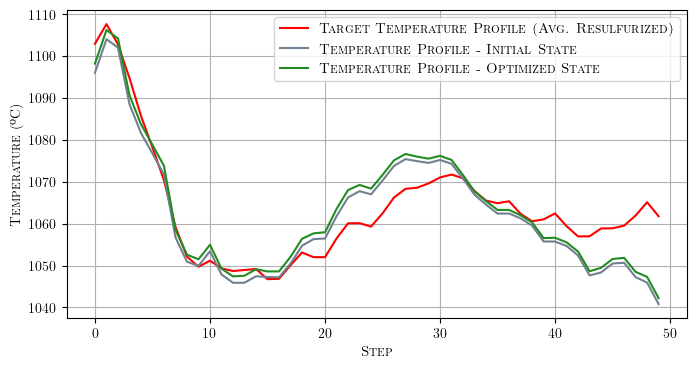

In [135]:
# REPRESENTACIÓN GRÁFICA: ESTADO DESEADO VS. ESTADO INCIAL VS. ESTADO ÓPTIMO
plt.figure(figsize=(8,4))

plt.plot(DESIRED_TEMPERATURE_PROFILE, label=r"\textsc{Target Temperature Profile (Avg. Resulfurized)}", color="red")
plt.plot(np.array(predict_temp_profile(np.array(INITIAL_STATE)).tolist()[0]), label=r"\textsc{Temperature Profile - Initial State}", color="slategrey")
plt.plot(np.array(predict_temp_profile(np.array(OPTIM_STATE).reshape(200,5).copy()).tolist()[0]), label=r"\textsc{Temperature Profile - Optimized State}", color="forestgreen")

plt.grid()
plt.xlabel(r"\textsc{Step}")
plt.ylabel(r"\textsc{Temperature} (ºC)")
plt.legend()
plt.savefig("plots/comparative-temp-profiles/comparative-temp-profiles-billet" + case_study_billet + ".png", dpi=1000)

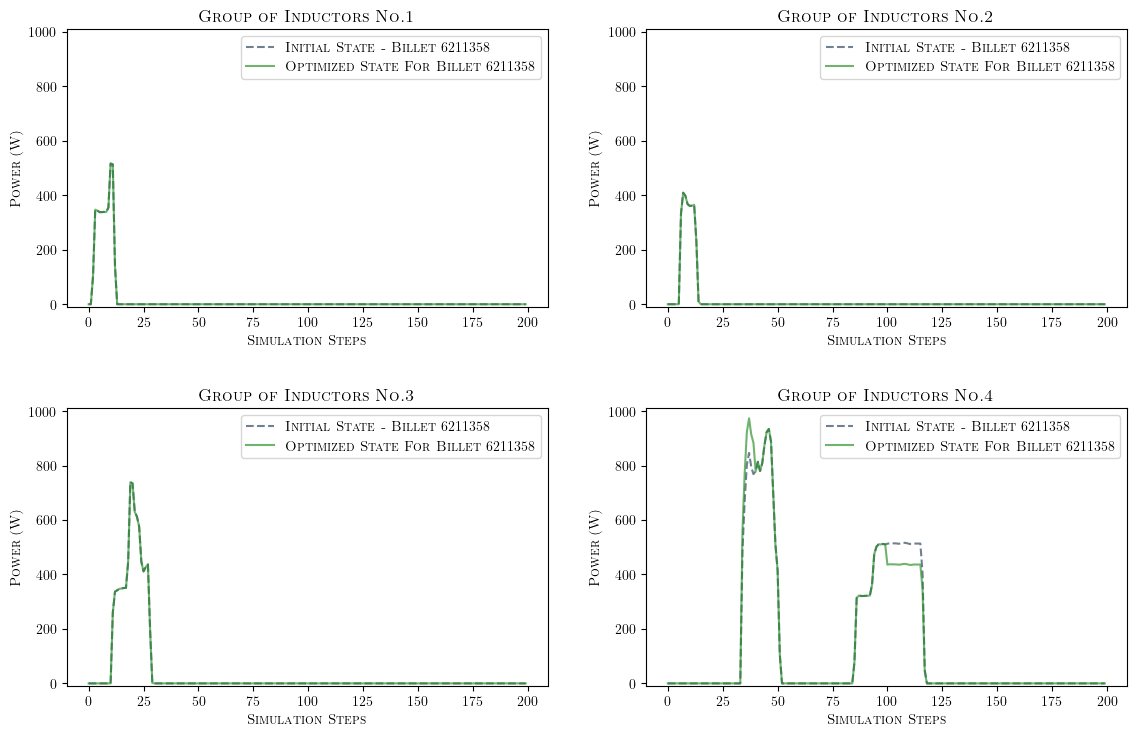

In [136]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

optim_state = np.array(OPTIM_STATE).reshape(200,5)
initial_state = INITIAL_STATE.reshape(200,5)

# Plot 1: POTENCIA INDUCTOR 1 VS. TIEMPO
axes[0, 0].plot(initial_state[:, 1], label=r"\textsc{Initial State - Billet }" + case_study_billet, color="slategrey", linestyle="--")
axes[0, 0].plot(optim_state[:, 1], label=r"\textsc{Optimized State For Billet }" + case_study_billet, color="forestgreen", alpha = 0.65)
axes[0, 0].set_xlabel(r"\textsc{Simulation Steps}")
axes[0, 0].set_ylabel(r"\textsc{Power (W)}")
axes[0, 0].set_title(r"\textsc{Group of Inductors No.1}")
axes[0, 0].legend(loc="upper right")
axes[0, 0].set_ylim(-10, 1010) 

# Plot 2: POTENCIA INDUCTOR 2 VS. TIEMPO
axes[0, 1].plot(initial_state[:, 2], label=r"\textsc{Initial State - Billet }" + case_study_billet, color="slategrey", linestyle="--")
axes[0, 1].plot(optim_state[:, 2], label=r"\textsc{Optimized State For Billet }" + case_study_billet, color="forestgreen", alpha = 0.65)
axes[0, 1].set_xlabel(r"\textsc{Simulation Steps}")
axes[0, 1].set_ylabel(r"\textsc{Power (W)}")
axes[0, 1].set_title(r"\textsc{Group of Inductors No.2}")
axes[0, 1].legend(loc="upper right")
axes[0, 1].set_ylim(-10, 1010) 

# Plot 3: POTENCIA INDUCTOR 3 VS. TIEMPO
axes[1, 0].plot(initial_state[:, 3], label=r"\textsc{Initial State - Billet }" + case_study_billet, color="slategrey", linestyle="--")
axes[1, 0].plot(optim_state[:, 3], label=r"\textsc{Optimized State For Billet }" + case_study_billet, color="forestgreen", alpha = 0.65)
axes[1, 0].set_xlabel(r"\textsc{Simulation Steps}")
axes[1, 0].set_ylabel(r"\textsc{Power (W)}")
axes[1, 0].set_title(r"\textsc{Group of Inductors No.3}")
axes[1, 0].legend(loc="upper right")
axes[1, 0].set_ylim(-10, 1010) 

# Plot 4: POTENCIA INDUCTOR 4 VS. TIEMPO
axes[1, 1].plot(initial_state[:, 4], label=r"\textsc{Initial State - Billet }" + case_study_billet, color="slategrey", linestyle="--")
axes[1, 1].plot(optim_state[:, 4], label=r"\textsc{Optimized State For Billet }" + case_study_billet, color="forestgreen", alpha = 0.65)
axes[1, 1].set_xlabel(r"\textsc{Simulation Steps}")
axes[1, 1].set_ylabel(r"\textsc{Power (W)}")
axes[1, 1].set_title(r"\textsc{Group of Inductors No.4}")
axes[1, 1].legend(loc="upper right")
axes[1, 1].set_ylim(-10, 1010)  

plt.tight_layout(pad=3.0)
plt.savefig("plots/optimized-heating-patterns/optimized-heating-pattern-billet" + case_study_billet + ".png", dpi=1000)
plt.show()